## MIDS UC Berkeley, Machine Learning at Scale <img src="http://www.candpgeneration.com/images/HW9-laugh-boy.png" style="float:right"/>
 
__W261-1__ Summer 2016    
__Week 9__: PageRank    

__Kyle Hamilton__   
kylehamilton@ischool.berkeley.edu  

July 11, 2016   

<a name="top"></a>
<h1>Contents</h1>
<h4>Chrome Extention to hide long output</h4>
<ul>
<li><a href="http://candpgeneration.com/261/add-extention.pdf">PDF - step by step install extension</a>
</li>
<li><a href="http://candpgeneration.com/261/chromeExtension.crx.zip">http://candpgeneration.com/261/chromeExtension.crx.zip</a>
<br>
Download and decompress. Then Drag into settings -> extensions </li>
</ul>


<h1 style="color:#021353;">HW 9.0: Short answer questions</h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">
What is PageRank and what is it used for in the context of web search?

What modifications have to be made to the webgraph in order to leverage the machinery of Markov Chains to 
compute the steady stade distibuton?

OPTIONAL: In topic-specific pagerank, how can we insure that the irreducible property is satified? (HINT: see HW9.4)
</pre>
</div>

### A.
PageRank is a measure of web page quality based on the structure of the hyperlink graph.
More precisely, PageRank is a probability distribution over nodes in the graph representing the likelihood that a random walk over the link structure will arrive at a particular node. Formally, the PageRank P of a page n is defined as follows:

$$p = \alpha*\left(\frac{1}{|G|}\right)+(1-\alpha) * \sum_{m \ \in \ L(n)}\frac{P(m)}{C(m)}$$

where |G| is the total number of nodes (pages) in the graph, α is the random jump factor, L( n) is the set of pages that link to n, and C(m) is the out-degree of node m (the number of links on page m). The random jump factor α is sometimes called the “teleportation” factor; alternatively, (1 – α) is referred to as the “damping” factor.

<hr>
### B.
The Markov Chain is a discrete-time stochastic process. The stochastic matrix has a principal left eigen vector corresponding to its largest eigen value wich is one. A Markov chain's probability distribution over its states may be viewed as a probability vector. This steady state probability for a state is the PageRank of the corresponding webpage. To compute the stable state distribution - PageRank - we can apply Markov Chains by repeatedly multiplying the web graoh by the transition matrix, until the values no longer change - they are stable.

In order for the Markov Chain to converge, it must be __ergodic__, namely, it must satisfy these conditions:
* __irriducibility__: There must be a sequence of tansitions of non-zero probability from any state to any other. In other words, the graph has to be connected (a path exists from all vetices to all vertices)
* __aperiodicity__: States are not partitioined into sets such that all state transitions occur cyclicly from one set to another

To compensate for the lack of these properties, Page and Brin introduced the Random Surfer model, whereby a damping factor as well as a teleportation factor are applied to each node to account for sinks and sources, or in other words, dangling nodes and disconnected components. See formula above.

<hr>
### C.
The requirements for irreducibility with topic-specific PageRank, the literature requires that
nodes not reachable from in-topic nodes be removed from the network. An alternative solution is proposed below (HW9.4)



<h1 style="color:#021353;">HW 9.1: MRJob implementation of basic PageRank</h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">

Write a basic MRJob implementation of the iterative PageRank algorithm
that takes sparse adjacency lists as input (as explored in HW 7).

Make sure that you implementation utilizes teleportation (1-damping/the number of nodes in the network), 
and further, distributes the mass of dangling nodes with each iteration
so that the output of each iteration is correctly normalized (sums to 1).

[NOTE: The PageRank algorithm assumes that a random surfer (walker), starting from a random web page,
chooses the next page to which it will move by clicking at random, with probability d,
one of the hyperlinks in the current page. This probability is represented by a so-called
‘damping factor’ d, where d ∈ (0, 1). Otherwise, with probability (1 − d), the surfer
jumps to any web page in the network. If a page is a dangling end, meaning it has no
outgoing hyperlinks, the random surfer selects an arbitrary web page from a uniform
distribution and “teleports” to that page]


As you build your code, use the test data

s3://ucb-mids-mls-networks/PageRank-test.txt
Or under the Data Subfolder for HW7 on Dropbox with the same file name. 
(On Dropbox https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0)

with teleportation parameter set to 0.15 (1-d, where d, the damping factor is set to 0.85), and crosscheck
your work with the true result, displayed in the first image
in the Wikipedia article:

https://en.wikipedia.org/wiki/PageRank

and here for reference are the corresponding PageRank probabilities:

A,0.033
B,0.384
C,0.343
D,0.039
E,0.081
F,0.039
G,0.016
H,0.016
I,0.016
J,0.016
K,0.016
</pre>
</div>

In [238]:
%%writefile PageRank-test-indexed.txt
2	{'3': 1}
3	{'2': 1}
4	{'1': 1, '2': 1}
5	{'4': 1, '2': 1, '6': 1}
6	{'2': 1, '5': 1}
7	{'2': 1, '5': 1}
8	{'2': 1, '5': 1}
9	{'2': 1, '5': 1}
10	{'5': 1}
11	{'5': 1}

Overwriting PageRank-test-indexed.txt


## Distributed PageRank
For each node, its current PageRank value p is updated to the final PageRank value p0 according to the following formula:

$$p = \alpha*\left(\frac{1}{N}\right)+(1-\alpha) * \left(\frac{m}{N} + p\right)$$

where N is the total number of nodes (pages) in the graph, α is the random jump factor. The random jump factor α is sometimes called the “teleportation” factor; alternatively, (1 – α) is referred to as the “damping” factor, and m is the missing mass from nodes with no out-links



## Initialize Graph and count number of Nodes
For this part we're going to use counters. This will allows us to have multiple mapper and reducers, and will run very quickly.

In [ ]:
%%writefile InitGraph.py
from __future__ import division
from mrjob.job import MRJob
from mrjob.protocol import JSONProtocol
from mrjob.step import MRStep
import json
import ast

class InitGraph(MRJob):

    MRJob.SORT_VALUES = True
    
    def configure_options(self):
        super(InitGraph, self).configure_options()
        
    def __init__(self, *args, **kwargs):
        super(InitGraph, self).__init__(*args, **kwargs)
    
    # mapper
    def encode_nodes(self,_,line):
        line = line.strip()
        node_id, links = line.split("\t")
        
        links = ast.literal_eval(links)
        node = {}
        
        if links is not None:
            node['links'] = sorted(links.items())

        node['score'] = 1
        
        yield "*N"+node_id, 1
        for e in links:
            yield "*N"+e, 1
            e_node = {}
            e_node['score'] = 1
            yield e, e_node

        yield node_id, node
    
    #reducer
    def intialize_mass(self,node_id,nodes):
        node = {}
        if node_id.startswith("*N"):
            self.increment_counter('N', 'N', 1)
        else:
            for n in nodes:
                n['score'] = 1
                node = dict(node, **n)
            yield node_id, node
            
    def steps(self):
        JOBCONF1 = {
            "mapreduce.map.memory.mb": "8192",                                    
            "mapreduce.map.java.opts": "-Xmx6144m",                                 
            "mapreduce.reduce.memory.mb": "8192",                                         
            "mapreduce.reduce.java.opts": "-Xmx6144m"
        }
        return ([MRStep(jobconf=JOBCONF1,
                    mapper=self.encode_nodes,
                    reducer=self.intialize_mass)
                ])        
            
            
if __name__ == '__main__':
    InitGraph.run() 

In [314]:
##############################################################################
# Driver for the Toy example graph
##############################################################################
import json
import time
from InitGraph import InitGraph

mr_job_init = InitGraph(args=['PageRank-test-indexed.txt'])
N = 0
start = time.time()
with mr_job_init.make_runner() as runner: 
    runner.run()
    print runner.counters()[0]
    N = runner.counters()[0]['N']['N'] #'N': 4196459645769
    
    
    with open('PageRank-test-init-graph.txt', 'w') as f:
            for line in runner.stream_output():
                key, value =  mr_job_init.parse_output_line(line)
                f.write("%s\t%s\n" % (key,json.dumps(value)))
    
    
end = time.time()
print end - start, " seconds to initialize graph"
print N

{'N': {'N': 11}}
0.0401990413666  seconds to initialize graph
11


In [ ]:
##############################################################################
# Driver for the Wikipedia graph
##############################################################################
import json
import time
from InitGraph import InitGraph
!aws s3 rm --recursive s3://ucb261-hw9/wiki_pageRank_init_graph/
mr_job_init = InitGraph(args=['-r','emr','s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt',
                              '--cluster-id=j-XVKQQ2YZTX1J',
                              '--output-dir=s3://ucb261-hw9/wiki_pageRank_init_graph'
                             ])
N = 0
start = time.time()
with mr_job_init.make_runner() as runner: 
    runner.run()
    print runner.counters()[0]
    N = runner.counters()[0]['N']['N'] #'N': 4196459645769
end = time.time()
print end - start, " seconds to initialize graph"
print N

    ec2_instance_type: m3.xlarge
    num_ec2_instances: 15
    1357.52049184  seconds to initialize graph ~22 mins
    N = 15192277

## Calculate PageRank
For this part we're not going to use counters. This is mainly because we are running this on EMR, and EMR writes intermediate output to S3. This takes a long time. In order to use counters we would have to run each iteration via the runner, thus forcing the intermediate output to S3. 

Instead, we're going to use an auxilary file to store the missing mass, such that it can be made available to all reducers in step two. And we'll let MRJob handle the iterations, thus saving intermediate files to HDFS. 

In [423]:
%%writefile MRPageRank_V2.py

"""Iterative implementation of the PageRank algorithm:
http://en.wikipedia.org/wiki/PageRank
"""
from __future__ import division
from mrjob.job import MRJob
from mrjob.protocol import JSONProtocol
from mrjob.step import MRStep
import json
import ast
import boto3


class MRPageRank_V2(MRJob):
    INPUT_PROTOCOL = JSONProtocol  # read the same format we write
    MRJob.SORT_VALUES = True
    
    def configure_options(self):
        super(MRPageRank_V2, self).configure_options()

        self.add_passthrough_option(
            '--iterations', dest='iterations', default=3, type='int',
            help='number of iterations to run')
        
        self.add_passthrough_option(
            '--N', dest='N', default=1, type='int',
            help='number of nodes')
        
        self.add_passthrough_option(
            '--damping-factor', dest='damping_factor', default=0.85,
            type='float',
            help='probability a web surfer will continue clicking on links')
        
    def __init__(self, *args, **kwargs):
        super(MRPageRank_V2, self).__init__(*args, **kwargs)
        
        
    # set all nodes to 1/N. this runs once, and takes about 2 minutes   
    def mapper_assign_intital_PR(self,node_id,node):
        node['score'] = 1/self.options.N
        yield node_id, node

    def mapper_one(self, node_id, node):
 
        if 'links' not in node:
            yield "missing_mass",node['score']
        else:
            num_outlinks = len(node['links'])
            for dest_id, w in node['links']:
                yield int(dest_id), ('score', node['score']/num_outlinks)
            
        yield int(node_id), ('node', node)   

    def reducer_one(self, node_id, values):
       
        node = {}
        new_score = 0
        
        if node_id == "missing_mass":
            missing_mass = sum(values)
            
            # TODO: logic if there are no dangleing nodes. Delete the tmp dir at end of run
            # Below, check for existence of missing mass file
            
            
            # --- writing to aux file --- #
            # TODO: to run the toy examples, provide ppassthrough option to run locally. 
            # Then store in local file system instead of S3.
            
            s3 = boto3.resource('s3')
            s3.Bucket('ucb261-hw9').put_object(Key='tmp/missing_massV2.txt', Body=json.dumps(missing_mass))

        else:
            for _type, value in values:
                if _type == 'node':
                    node = value
                elif _type == 'score':
                    new_score += value
        
            node['score'] = new_score
            yield node_id, node
            
    def mapper_two_init(self):
        self.missing_mass = 0
        # TODO: check for existence of missing mass file.
        s3 = boto3.resource('s3')
        mm = s3.Object('ucb261-hw9','tmp/missing_massV2.txt')
        
        self.missing_mass = float(mm.get()["Body"].read())
        
    def mapper_two(self,node_id,node):
        
        d = self.options.damping_factor
        a = 1 - d
        m = self.missing_mass
        N = self.options.N
        
        new_score = a*(1/N) + d*(m/N + node['score'])
        
        node['score'] = new_score
        yield node_id, node
          
        
    def steps(self):
        JOBCONF1 = {
            "mapreduce.map.memory.mb": "8192",                                    
            "mapreduce.map.java.opts": "-Xmx6144m",                                 
            "mapreduce.reduce.memory.mb": "8192",                                         
            "mapreduce.reduce.java.opts": "-Xmx6144m"
        }
        JOBCONF2 = {
            "mapreduce.map.memory.mb": "8192",                                    
            "mapreduce.map.java.opts": "-Xmx6144m",                                 
            "mapreduce.reduce.memory.mb": "8192",                                         
            "mapreduce.reduce.java.opts": "-Xmx6144m"
        }
        JOBCONF3 = {
            "mapreduce.map.memory.mb": "8192",                                    
            "mapreduce.map.java.opts": "-Xmx6144m",                                 
            "mapreduce.reduce.memory.mb": "8192",                                         
            "mapreduce.reduce.java.opts": "-Xmx6144m"
        }
        return ([MRStep(jobconf=JOBCONF1,
                    mapper=self.mapper_assign_intital_PR)] +
                [MRStep(jobconf=JOBCONF2,
                    mapper=self.mapper_one, 
                    reducer=self.reducer_one),
                 MRStep(jobconf=JOBCONF3,
                    mapper_init=self.mapper_two_init,    
                    mapper=self.mapper_two)] * 
                    self.options.iterations)


if __name__ == '__main__':
    MRPageRank_V2.run()

Overwriting MRPageRank_V2.py


##############################################################################
## Driver for the Toy example graph
##############################################################################

In [424]:
import json
import time
from MRPageRank_V2 import MRPageRank_V2

mr_job_toy = MRPageRank_V2(args=['PageRank-test-init-graph.txt','--N=11','--iterations=10'])
total_PR = 0
start = time.time()
with mr_job_toy.make_runner() as runner: 
    runner.run()
    
    for line in runner.stream_output():
        key, value =  mr_job_toy.parse_output_line(line)
        total_PR += value['score']
        print("%s\t%s" % (key,json.dumps(value)))
    
    
end = time.time()
print '\nTotal PapgeRank should sum to 1: ',total_PR
print end - start, " seconds to run the toy example graph"

1	{"score": 0.03293010178620472}
10	{"score": 0.016207127344124005, "links": [["5", 1]]}
11	{"score": 0.016207127344124005, "links": [["5", 1]]}
2	{"score": 0.36323594898891026, "links": [["3", 1]]}
3	{"score": 0.3628837280387178, "links": [["2", 1]]}
4	{"score": 0.03938466342002968, "links": [["1", 1], ["2", 1]]}
5	{"score": 0.08114525762548769, "links": [["2", 1], ["4", 1], ["6", 1]]}
6	{"score": 0.03938466342002968, "links": [["2", 1], ["5", 1]]}
7	{"score": 0.016207127344124005, "links": [["2", 1], ["5", 1]]}
8	{"score": 0.016207127344124005, "links": [["2", 1], ["5", 1]]}
9	{"score": 0.016207127344124005, "links": [["2", 1], ["5", 1]]}

Total PapgeRank should sum to 1:  1.0
15.1758041382  seconds to run the toy example graph


############################################################################################################
## Drivers for the Wikipedia graph
############################################################################################################

In [ ]:
from MRPageRank_V2 import MRPageRank_V2
import time
# !aws s3 rm --recursive s3://ucb261-hw9/wiki_pageRank_V2_5ITER
mr_job = MRPageRank_V2(args=['-r','emr','s3://ucb261-hw9/wiki_pageRank_init_graph',
                          '--cluster-id=j-XVKQQ2YZTX1J',
                          '--N=15192277',
                          '--damping-factor=0.85',
                          '--iterations=5',
                          '--output-dir=s3://ucb261-hw9/wiki_pageRank_V2_5ITER'
                        ])

                
with mr_job.make_runner() as runner: 
    runner.run()

In [ ]:
############################################################################################################
# TODO: For the 10 iteration job, do not rerun the first 5 iterations, instead use the output from the first  
# 5 iterations as input to the 10 iteration job and run 5 times instead of 10. A minor change is required in  
# the code to prevent the initialization step from setting all node scores to 1/N. provide a passthough option
# to state whther this is a subsequent run, and provide logic to bypass the first mapper job.
############################################################################################################

from MRPageRank_V2 import MRPageRank_V2
import time
# !aws s3 rm --recursive s3://ucb261-hw9/wiki_pageRank_V2_10ITER
mr_job = MRPageRank_V2(args=['-r','emr','s3://ucb261-hw9/wiki_pageRank_init_graph',
                          '--cluster-id=j-XVKQQ2YZTX1J',
                          '--N=15192277',
                          '--damping-factor=0.85',
                          '--iterations=10',
                          '--output-dir=s3://ucb261-hw9/wiki_pageRank_V2_10ITER'
                        ])

                
with mr_job.make_runner() as runner: 
    runner.run()


5 Iterations
---------------------------------
    ec2_instance_type: m3.xlarge
    num_ec2_instances: 15
    
    Time to complete each step:
    
    4  minutes
    21 minutes
    3  minutes
    21 minutes
    3  minutes
    22 minutes
    3  minutes
    21 minutes ^^ rinse/lather/repeat steps 1 and 2
    3  minutes <- step 2 - recalculate PageRank, mapper only
    21 minutes <- step 1 - collect and aggregate dangling mass, mapper and reducer
    ---------------------------------------------------------------------
    2  minutes <- mapper sets all scores to 1/N. No reducer
    
    TOTAL: 124 minutes = ~2 hours
    
10 Iterations
---------------------------------
    ec2_instance_type: m3.xlarge
    num_ec2_instances: 15

    Time to complete each step:
    
    3  minutes
    22 minutes
    3  minutes
    20 minutes
    3  minutes
    21 minutes
    3  minutes
    21 minutes
    3  minutes
    21 minutes
    3  minutes
    21 minutes
    3  minutes
    21 minutes
    3  minutes
    20 minutes
    3  minutes
    22 minutes ^^ rinse/lather/repeat steps 1 and 2
    3  minutes <- step 2 - recalculate PageRank, mapper only
    22 minutes <- step 1 - collect and aggregate dangling mass, mapper and reducer
    ---------------------------------------------------------------------
    2  minutes <- mapper sets all scores to 1/N. No reducer
    
    TOTAL: 243 minutes = ~4 hours

It's clear from these timings that the first MR step of the job takes significantly longer than the second which contains only a mapper. The shuffle-sort phase does not come for free. <strong>Also, writing to an auxilary file in S3 is not ideal. The reason for this implmentation is the fact that we are <span style="color:#ff0055">working in EMR, and any intermediate files are written to S3</span>. This would make using counters even less eficient than writing said file.</strong>

<h1 style="color:#021353;">HW 9.2: Exploring PageRank teleportation and network plots</h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">

In order to overcome  problems such as disconnected components, the damping factor (a typical value for d is 0.85) can be varied. 

Using the graph in HW1, plot the test graph (using networkx, https://networkx.github.io/) for several values of the damping parameter alpha,
so that each nodes radius is proportional to its PageRank score. In particular you should
do this for the following damping factors: [0,0.25,0.5,0.75, 0.85, 1]. Note your plots should look like the following:

https://en.wikipedia.org/wiki/PageRank#/media/File:PageRanks-Example.svg
</pre>
</div>

In [326]:
%%bash
#!/bin/bash
# Run the PageRank algorithm for damping factors: 0 0.25 0.5  0.75 0.85 1

mkdir dump
NUMBERS='0 0.25 0.5  0.75 0.85 1'

for number in `echo $NUMBERS` 
do
  python MRPageRank_V2.py --N=11 --iterations=10 --damping-factor="$number" PageRank-test-init-graph.txt > dump/"$number"
  echo -n "$number "
done

echo 
exit 0

0 0.25 0.5 0.75 0.85 1 


Using configs in /etc/mrjob.conf
ignoring partitioner keyword arg (requires real Hadoop): 'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
Creating temp directory /var/folders/2f/rb8qqgd55bl77zgchyxsfl7h0000gp/T/MRPageRank_V2.koza.20160717.143202.403183
Running step 1 of 21...
Running step 2 of 21...
Running step 3 of 21...
Running step 4 of 21...
Running step 5 of 21...
Running step 6 of 21...
Running step 7 of 21...
Running step 8 of 21...
Running step 9 of 21...
Running step 10 of 21...
Running step 11 of 21...
Running step 12 of 21...
Running step 13 of 21...
Running step 14 of 21...
Running step 15 of 21...
Running step 16 of 21...
Running step 17 of 21...
Running step 18 of 21...
Running step 19 of 21...
Running step 20 of 21...
Running step 21 of 21...
Streaming final output from /var/folders/2f/rb8qqgd55bl77zgchyxsfl7h0000gp/T/MRPageRank_V2.koza.20160717.143202.403183/output...
Removing temp directory /var/folders/2f/rb8qqgd55bl77zgchyxsfl7h0000gp/T/MRPageRank_V2.koza.20

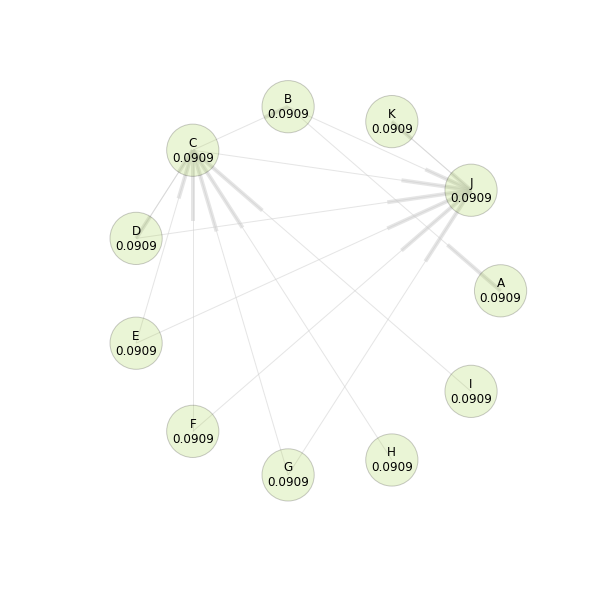

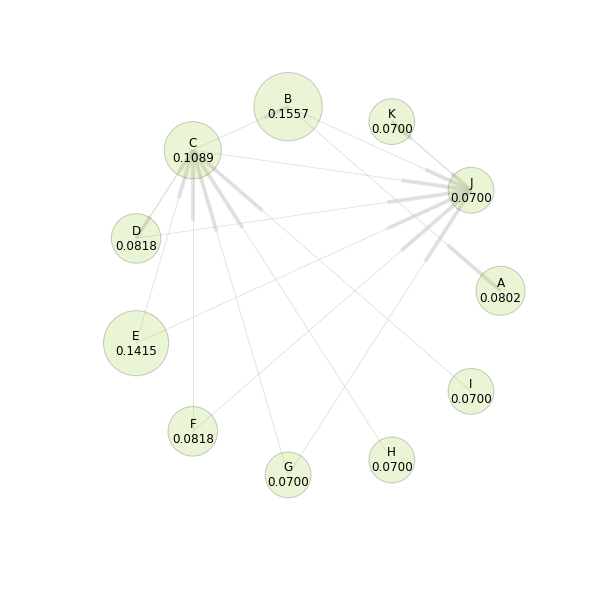

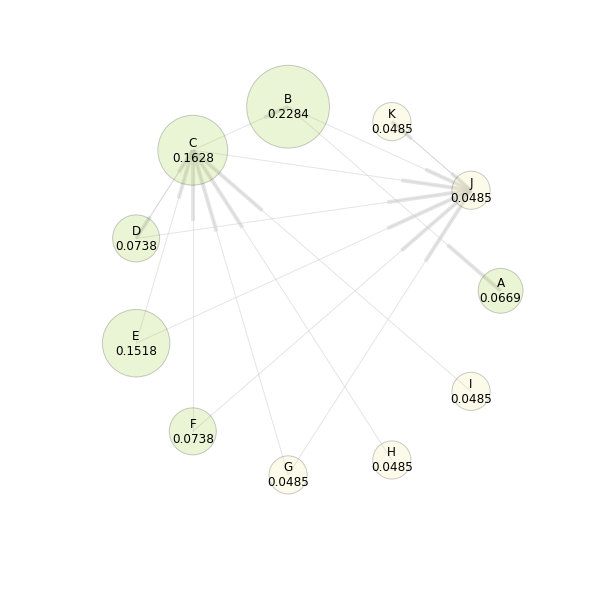

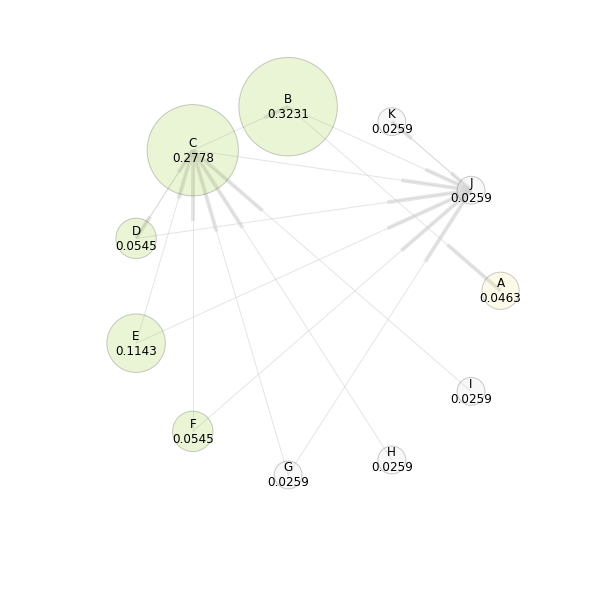

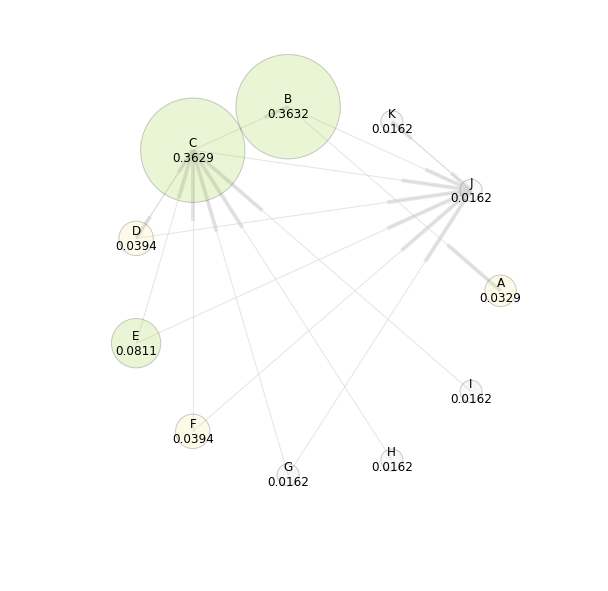

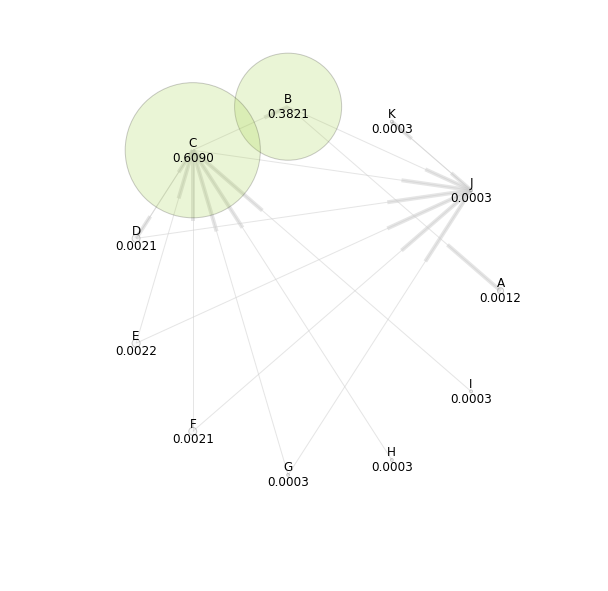

In [414]:
%matplotlib inline
import ast
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

def drawGraph(d):
    nodes = []
    sizes = []
    edgelist = []

    with open("dump/"+str(d),"r") as f:
        for line in f.readlines():
            line = line.strip()
            node, values = line.split("\t")
            values = ast.literal_eval(values)
            nodes.append(int(node))
            sizes.append(values['score'])
            for link in values.get('links') or []:
                edgelist.append((int(node),int(link[0])))

    plt.figure(figsize=(10, 10))
    G=nx.DiGraph()
    for edge in edgelist:
        G.add_edge(edge[0],edge[1])
    pos=nx.circular_layout(G) # positions for all nodes
    node_colors = []
    for node in G.nodes():
        labels[node] = '{}\n{}'.format(chr(nodes[node-1]+64), "{:.4f}".format(sizes[node-1]))

        if sizes[node-1]   > 0.05: node_colors.append('YellowGreen')
        elif sizes[node-1] > 0.03: node_colors.append('Khaki')
        elif sizes[node-1] >  0.1: node_colors.append('Khaki')
        else:                      node_colors.append('Gainsboro')

    nx.draw_networkx_nodes(G,pos,
                           node_color=node_colors,
                           node_size=map(lambda x: x*30000, sizes),
                           edge_color=None,
                           alpha=.2)

    nx.draw_networkx_edges(G,pos,width=1,alpha=0.5,edge_color='#cccccc')
    nx.draw_networkx_labels(G,pos,labels,font_size=12)


    plt.axis('off')
    plt.savefig("damp/"+str(d)+".png")
    plt.show()

    
damps = [0,0.25,0.5,0.75, 0.85, 1]
for d in damps:
    drawGraph(d)

<h1 style="color:#021353;">HW 9.3: Applying PageRank to the Wikipedia hyperlinks network</h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">

Run your PageRank implementation on the Wikipedia dataset for 5 iterations,
and display the top 100 ranked nodes (with alpha = 0.85).

Run your PageRank implementation on the Wikipedia dataset for 10 iterations,
and display the top 100 ranked nodes (with teleportation factor of 0.15). 

Have the top 100 ranked pages changed? Comment on your findings. Plot the pagerank values for the top 100 pages resulting from the 5 iterations run. Then plot the pagerank values for the same 100 pages that resulted from the 10 iterations run.  
</pre>
</div>

#### (PageRank was run as part of 9.1 - see drivers above)
## Extract top 100 (+) pages

In [268]:
%%writefile SortPageRank.py

from __future__ import division
from mrjob.job import MRJob
from mrjob.protocol import JSONProtocol
from mrjob.step import MRStep
import json
import ast
import heapq as hp


class SortPageRank(MRJob):

    def configure_options(self):
        super(SortPageRank, self).configure_options()

        
    def __init__(self, *args, **kwargs):
        super(SortPageRank, self).__init__(*args, **kwargs)
        self.topScores = [(0,0) for i in range(100)]
    
    def mapper(self,_,line):
        # @input:
        # 12072155	{"score": 1.07224068920815e-08, "N": 15192277}
        line = line.strip()
        node_id, value = line.split("\t")
        value = ast.literal_eval(value)
        score = float(value['score'])*1000000000 # hack to fix sorting issue with scientific notation
        hp.heappushpop(self.topScores, (score,node_id))
    
    def mapper_final(self):
        for i in self.topScores:
            yield i[0],i[1]
        
    def reducer(self,score,nodes):
        for node in nodes:
             yield score, node
            
    def steps(self):
       
        JOBCONF2 = {
              'mapred.output.key.comparator.class':'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
              'mapred.text.key.comparator.options': '-k1nr',
              'mapred.reduce.tasks': '1'
            # Only using one reducer, becuase we are only keeping a small subset of the data.
            # Final file will contain this many rows: Number of topScores (100) * the number of map tasks
            # This reduces cost of storage, and makes sorting much easier to code 
        }
        return (
                [MRStep(jobconf=JOBCONF2,
                    mapper=self.mapper, 
                    mapper_final=self.mapper_final,
                    reducer=self.reducer)
                ]
               )
            
            
if __name__ == '__main__':
    SortPageRank.run()  

Overwriting SortPageRank.py


In [286]:
!mrjob create-cluster --max-hours-idle 1

Using configs in /etc/mrjob.conf
Using s3://mrjob-891b290ee7cbecec/tmp/ as our temp dir on S3
Creating persistent cluster to run several jobs in...
Creating temp directory /var/folders/2f/rb8qqgd55bl77zgchyxsfl7h0000gp/T/no_script.koza.20160717.134145.397752
Copying local files to s3://mrjob-891b290ee7cbecec/tmp/no_script.koza.20160717.134145.397752/files/...
j-11UFYZEY41ZVF


In [792]:
###################################################################
# Extract top 100 after 5 iterations
###################################################################
!aws s3 rm --recursive s3://ucb261-hw9/wiki_pageRank_top100_V2_5ITER
!python SortPageRank.py -r emr s3://ucb261-hw9/wiki_pageRank_V2_5ITER  \
    --cluster-id=j-11UFYZEY41ZVF \
    --output-dir=s3://ucb261-hw9/wiki_pageRank_top100_V2_5ITER
## OUTOUT SUPRESSED 

In [795]:
###################################################################
# Extract top 100 after 10 iterations
###################################################################
!aws s3 rm --recursive s3://ucb261-hw9/wiki_pageRank_top100_V2
!python SortPageRank.py -r emr s3://ucb261-hw9/wiki_pageRank_V2_10ITER  \
    --cluster-id=j-11UFYZEY41ZVF \
    --output-dir=s3://ucb261-hw9/wiki_pageRank_top100_V2_10ITER
## OUTOUT SUPRESSED

In [289]:
!aws s3 ls s3://ucb261-hw9/wiki_pageRank_top100_V2_5ITER/
!aws s3 ls s3://ucb261-hw9/wiki_pageRank_top100_V2_10ITER/

2016-07-17 09:49:53          0 _SUCCESS
2016-07-17 09:49:52     314414 part-00000
2016-07-17 09:53:43          0 _SUCCESS
2016-07-17 09:53:42     314393 part-00000


In [290]:
!aws s3 cp s3://ucb261-hw9/wiki_pageRank_top100_V2_5ITER/part-00000  wiki_PR_top_5iterations_V2.txt
!aws s3 cp s3://ucb261-hw9/wiki_pageRank_top100_V2_10ITER/part-00000  wiki_PR_top_10iterations_V2.txt

download: s3://ucb261-hw9/wiki_pageRank_top100_V2_5ITER/part-00000 to ./wiki_PR_top_5iterations_V2.txt
download: s3://ucb261-hw9/wiki_pageRank_top100_V2_10ITER/part-00000 to ./wiki_PR_top_10iterations_V2.txt


In [361]:
!head -n 100 wiki_PR_top_5iterations_V2.txt > wiki_PR_top100_5iterations_V2.txt

# We need more than just the top 100 from the 10 iteration job, for the plot below.
# So we'll join with this slightly bigger set of 1000 results
!head -n 1000 wiki_PR_top_10iterations_V2.txt > wiki_PR_top1000_10iterations_V2.txt


## Join with index to get page titles
This is a simple in-memory hash map join where the smaller file is only 100-1000 rows. 

In [346]:
%%writefile joinWithIndex.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

import mrjob
from mrjob.protocol import RawValueProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
import csv
import json
import re
import sys


class joinWithIndex(MRJob):
    
    def configure_options(self):
        super(joinWithIndex, self).configure_options()
        self.add_passthrough_option(
            '--iterations', type='str', default=5, help='Select the target node')
        self.add_file_option(
            '--topresultsfile', type='str', default="tmp.txt", help='Provide the file name')
        
    def steps(self):
        JOBCONF_STEP1 = {  
            'mapred.output.key.comparator.class':'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapred.text.key.comparator.options': '-k1nr',
            "mapred.reduce.tasks":1
            # ^^ Only need one reducer since we will end up with a small file
        }
        return [MRStep(jobconf=JOBCONF_STEP1,
            mapper_init = self.mapper_init,
            mapper = self.mapper,
            reducer = self.reducer    
        )]

    def mapper_init(self):
        self.nodes = {}
        f = open(self.options.topresultsfile,"r")
        # @input: 489685.32066759164	"13455888"
        for line in f:
            line = line.strip()
            score,node_id = line.split("\t")
            node_id = node_id.replace('"','')
            self.nodes[node_id] = float(score)

    def mapper(self,_,line):
        line = line.strip()
        title, indx, inDeg, outDeg = line.split("\t")
        
        if indx in self.nodes:
            yield self.nodes[indx], (indx, title)
            
    def reducer(self, key, value):
        for v in value:
            yield key, v

if __name__ == '__main__':
    joinWithIndex.run()

Overwriting joinWithIndex.py


In [359]:
###################################################################
# Join top 100 with index after 5 iterations
###################################################################

!aws s3 rm --recursive s3://ucb261-hw9/top_5iter_names
!python joinWithIndex.py -r emr s3://ucb-mids-mls-networks/wikipedia/indices.txt \
    --topresultsfile=wiki_PR_top100_5iterations_V2.txt \
    --iterations=5 \
    --cluster-id=j-11UFYZEY41ZVF \
    --output-dir=s3://ucb261-hw9/top_5iter_names

Using configs in /etc/mrjob.conf
Using s3://mrjob-891b290ee7cbecec/tmp/ as our temp dir on S3
Could not infer endpoint for bucket ucb-mids-mls-networks; assuming s3.amazonaws.com
Creating temp directory /var/folders/2f/rb8qqgd55bl77zgchyxsfl7h0000gp/T/joinWithIndex.koza.20160717.161744.763341
Copying local files to s3://mrjob-891b290ee7cbecec/tmp/joinWithIndex.koza.20160717.161744.763341/files/...
Adding our job to existing cluster j-11UFYZEY41ZVF
Detected hadoop configuration property names that do not match hadoop version 2.4.0:
The have been translated as follows
 mapred.output.key.comparator.class: mapreduce.job.output.key.comparator.class
mapred.reduce.tasks: mapreduce.job.reduces
mapred.text.key.comparator.options: mapreduce.partition.keycomparator.options
Waiting for step 1 of 1 (s-SNFWS6CL92AK) to complete...
  Opening ssh tunnel to resource manager...
  Connect to resource manager at: http://localhost:40400/cluster
  RUNNING for 20.2s
Unable to connect to resource manager
  RU

In [363]:
###################################################################
# Join top 100+ with index after 10 iterations
###################################################################

!aws s3 rm --recursive s3://ucb261-hw9/top_10iter_names
!python joinWithIndex.py -r emr s3://ucb-mids-mls-networks/wikipedia/indices.txt \
    --topresultsfile=wiki_PR_top1000_10iterations_V2.txt \
    --iterations=10 \
    --cluster-id=j-11UFYZEY41ZVF \
    --output-dir=s3://ucb261-hw9/top_10iter_names


Using configs in /etc/mrjob.conf
Using s3://mrjob-891b290ee7cbecec/tmp/ as our temp dir on S3
Could not infer endpoint for bucket ucb-mids-mls-networks; assuming s3.amazonaws.com
Creating temp directory /var/folders/2f/rb8qqgd55bl77zgchyxsfl7h0000gp/T/joinWithIndex.koza.20160717.163427.578734
Copying local files to s3://mrjob-891b290ee7cbecec/tmp/joinWithIndex.koza.20160717.163427.578734/files/...
Adding our job to existing cluster j-11UFYZEY41ZVF
Detected hadoop configuration property names that do not match hadoop version 2.4.0:
The have been translated as follows
 mapred.output.key.comparator.class: mapreduce.job.output.key.comparator.class
mapred.reduce.tasks: mapreduce.job.reduces
mapred.text.key.comparator.options: mapreduce.partition.keycomparator.options
Waiting for step 1 of 1 (s-SMEW5ERZ2ZXT) to complete...
  PENDING (cluster is WAITING: Cluster ready after last step completed.)
  Opening ssh tunnel to resource manager...
  Connect to resource manager at: http://localhost:404

In [364]:
!aws s3 ls s3://ucb261-hw9/top_5iter_names/
!aws s3 ls s3://ucb261-hw9/top_10iter_names/

2016-07-17 12:19:12          0 _SUCCESS
2016-07-17 12:19:12       4631 part-00000
2016-07-17 12:36:11          0 _SUCCESS
2016-07-17 12:36:10      47846 part-00000


In [365]:
!aws s3 cp s3://ucb261-hw9/top_5iter_names/part-00000 top_5iter_names.txt
!aws s3 cp s3://ucb261-hw9/top_10iter_names/part-00000 top_10iter_names.txt

download: s3://ucb261-hw9/top_5iter_names/part-00000 to ./top_5iter_names.txt
download: s3://ucb261-hw9/top_10iter_names/part-00000 to ./top_10iter_names.txt


In [366]:
# The top results from 10 iterations deliberately have more than 100 rows so it can be merged with the 5 iteration 
# results which have some titles that the top 100 in the 10 iteration results does not.
!wc -l top_10iter_names.txt

    1000 top_10iter_names.txt


# 9.3 Results

In [356]:
from __future__ import division
import json

def printTop100(n):
    counter = 0
    print "="*100
    print "{:10s}\t| {:10s}\t| {}".format("PageRank","Page id","Title") 
    print "="*100
    with open("top_"+str(n)+"iter_names.txt","r") as f:
        for line in f.readlines():
            counter +=1
            line = line.strip()
            score, value = line.split('\t')
            score = float(score)/1000000000 # hack to get the original scores back.
            value = json.loads(value)
            print "{:6f}\t| {:10s}\t| {}".format(score,value[0],value[1]) 
            
            # See reson for this logic above.
            if counter == 100:
                break

print "After 5 iterations\n"             
printTop100(5)

print "\nAfter 10 iterations\n"             
printTop100(10)

After 5 iterations

PageRank  	| Page id   	| Title
0.001461	| 13455888  	| United States
0.000683	| 1184351   	| Animal
0.000643	| 4695850   	| France
0.000576	| 5051368   	| Germany
0.000460	| 1384888   	| Arthropod
0.000458	| 7902219   	| List of sovereign states
0.000455	| 6113490   	| Insect
0.000446	| 2437837   	| Canada
0.000430	| 6076759   	| India
0.000429	| 13425865  	| United Kingdom
0.000422	| 4196067   	| England
0.000409	| 6172466   	| Iran
0.000382	| 14112583  	| World War II
0.000369	| 10390714  	| Poland
0.000350	| 15164193  	| village
0.000345	| 3191491   	| Countries of the world
0.000332	| 7835160   	| List of countries
0.000331	| 6416278   	| Japan
0.000328	| 6237129   	| Italy
0.000325	| 1516699   	| Australia
0.000321	| 13725487  	| Voivodeships of Poland
0.000314	| 7576704   	| Lepidoptera
0.000313	| 9276255   	| National Register of Historic Places
0.000311	| 10469541  	| Powiat
0.000305	| 5154210   	| Gmina
0.000280	| 7990491   	| London
0.000277	| 12836211  	

## Plot top 100 pages

First plot the top 100 pages for the 5 iteration run. Then overlay with the 10 iteration run by joining the 10 iteration results with th 5 iteration results.

Running the job for another 5 iterations does not change the results much. Or to put it differently, it appears that the algorithm is close to converging after just 5 iterations. it would be interesting to see what happens after many more iterations, or to run the job until it actually converges. However, this is cost prohibitive at this time.

In [367]:
%reload_ext autoreload
%autoreload 2

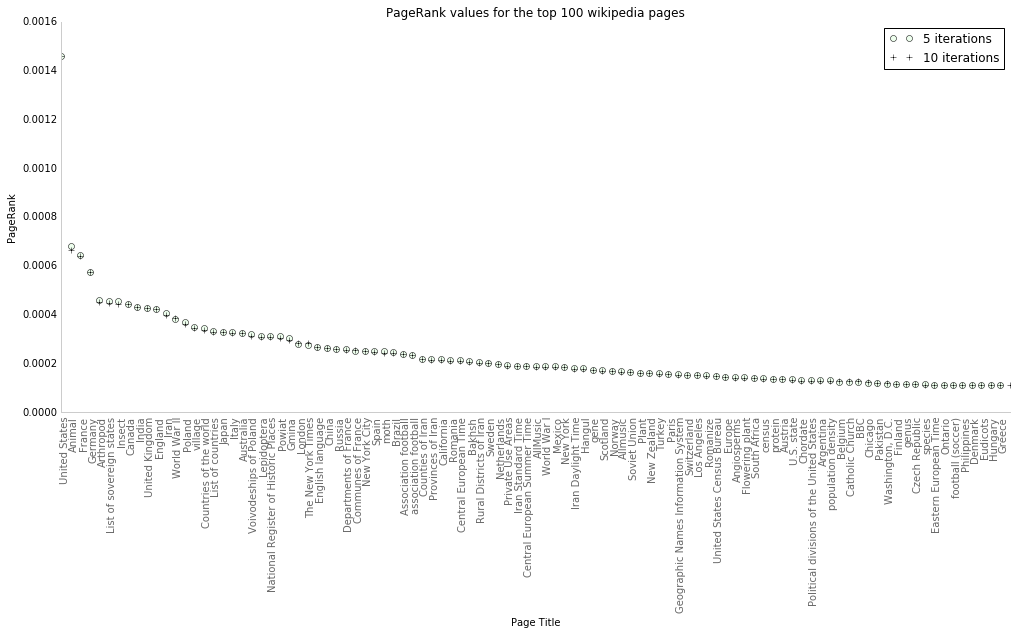

In [370]:
%matplotlib inline
from __future__ import division
import numpy as np
import pylab as pl
import itertools
from random import shuffle

data5 = []
data10 = []
A = {}
B = {}

for line in open("top100_5iter_names.txt").readlines():
    line = line.strip()
    score, value = line.split('\t')
    value = json.loads(value)
    Y = float(score)/1000000000
    X = value[1]
    data5.append([X,Y])
    A[X] = Y
    
for line in open("top100_10iter_names.txt").readlines():
    line = line.strip()
    score, value = line.split('\t')
    value = json.loads(value)
    Y = float(score)/1000000000
    X = value[1]
    data10.append([X,Y])
    B[X] = Y

#join the 10 iteration results with the 5 iteration results:    
for item in data5:
    key = item[0]
    score = B.get(key) or 0
    data10.append([ key, score ])
    

items10 = (np.array(data10).T)  
items5 = (np.array(data5).T)

fig = pl.figure(figsize=(17,7))
ax = pl.subplot(111)
width=0.7
# ax.bar(range(len(items5[0])), items5[1], width=width,color="#fc0668",edgecolor = "none")
ax.set_xticks(np.arange(len(items5[0])) + width/2)
ax.set_xticklabels(items5[0], rotation=90, color="#666666")

ax.plot(items5[1],'o',c="#eeffee",label='5 iterations')
ax.plot(items10[1],'+k', label='10 iterations')


pl.tick_params(
            axis='both', 
            which='both',
            bottom='off',
            left='off',
            top='off',
            right='off'
#             labelleft='off',
#             labelbottom='off'
)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('#cccccc')
ax.spines['bottom'].set_color('#cccccc')
pl.legend()
pl.xlim([0,len(data)])
pl.ylabel("PageRank")
pl.xlabel("Page Title")
pl.title("PageRank values for the top 100 wikipedia pages")
pl.show()


<h1 style="color:#021353;">HW 9.4: Topic-specific PageRank implementation using MRJob</h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">
Modify your PageRank implementation to produce a topic specific PageRank implementation,
as described in:

http://www-cs-students.stanford.edu/~taherh/papers/topic-sensitive-pagerank.pdf

Note in this article that there is a special caveat to ensure that the transition matrix is irreducible.
This caveat lies in footnote 3 on page 3:

	A minor caveat: to ensure that M is irreducible when p
	contains any 0 entries, nodes not reachable from nonzero
	nodes in p should be removed. In practice this is not problematic.

and must be adhered to for convergence to be guaranteed.

Run topic specific PageRank on the following randomly generated network of 100 nodes:

s3://ucb-mids-mls-networks/randNet.txt (also available on Dropbox)

which are organized into ten topics, as described in the file:

s3://ucb-mids-mls-networks/randNet_topics.txt  (also available on Dropbox)

Since there are 10 topics, your result should be 11 PageRank vectors
(one for the vanilla PageRank implementation in 9.1, and one for each topic
with the topic specific implementation). Print out the top ten ranking nodes 
and their topics for each of the 11 versions, and comment on your result. 
Assume a teleportation factor of 0.15 in all your analyses.

One final and important comment here:  please consider the 
requirements for irreducibility with topic-specific PageRank.
In particular, the literature ensures irreducibility by requiring that
nodes not reachable from in-topic nodes be removed from the network.

This is not a small task, especially as it it must be performed
separately for each of the (10) topics.

So, instead of using this method for irreducibility, 
please comment on why the literature's method is difficult to implement,
and what what extra computation it will require.
Then for your code, please use the alternative, 
non-uniform damping vector:
</pre>
</div>
$$v_{ji} = beta*\left(\frac{1}{|T_j|}\right) \ if \ node  \ i \ lies \ in \ topic \ T_j$$

$$v_{ji} = (1-beta)*\left(\frac{1}{N - |T_j|}\right) \ if \ node \ i \ lies \ outside \ of \ topic \ T_j$$


<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">
for beta in (0,1) close to 1. 

With this approach, you will not have to delete any nodes.
If beta > 0.5, PageRank is topic-sensitive, 
and if beta < 0.5, the PageRank is anti-topic-sensitive. 
For any value of beta irreducibility should hold,
so please try beta=0.99, and perhaps some other values locally,
on the smaller networks.
</pre>
</div>

# Answers - HW 9.4  (+9.5)

I think removing nodes would require generating new outlink and inlink counts, and recalculating missing mass. This would need to be done for each topic strating from the original dataset. By using the alternative method of non-uniform damping, we can calculate all scores in one pass over the data while keeping a list of scores for each topic.

I've tried to write the answer to 9.4 in a way that would scale and allow us to answer 9.5. For this purpose I have a Total-Order-Sort class which partitions and sorts each topic such that the top results are guaranteed to be saved in part-00000 of each directory.

## 9.4 A. Join

A Reduce Side join is most approriate for this question. See below.

#### An alternative Map Side Parallel Join implementation can be found here:    
http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/krl3jdmdufvzj98/MapSideParallelScanJoin.ipynb     
#### Some helper functions:  
http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/w5ke40jzx9gkmht/Helper%20functions%20for%209.4%20and%209.5.ipynb

#### The Map Side Parallel Join implementation does the following steps 

<ol>
<li>
Partition both datasets <strong>on the node id as key</strong> in exactly the same way (<em>not to be confused with the total-order-sort partion phase which uses the scores to generate partition keys</em>).     
</li>
<li>
Join by streaming in the larger dataset (graph), and reading in a partition at a time of the smaller set (indexes) and creating an in-memory HashMap. By using the <strong>mapreduce_map_input_file</strong> property we can read in the part-xxxxx file corresponding to the part-xxxxx file being streamed in.
</li>
</ol>

Ref: 
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.186.2132&rep=rep1&type=pdf

There is another more elegant Map Side join. Hadoop provides a class "CompositeInputFormat" which is a pre map phase join. If both data sets are partitioned and sorted exactly the same way, the CompositeInputFormat allows to read from two input streams. This is not available to MRJob (or even hadoop streaming) as far as I can tell.    
ref: http://hadoop.apache.org/docs/current2/api/org/apache/hadoop/mapreduce/lib/join/CompositeInputFormat.html



### Reduce Side Join
Since we have a one-to-one mapping no special (left, right, inner) logic is necessary

In [ ]:
%%writefile reduceSideJoin.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

import re
import ast
import mrjob
from mrjob.job import MRJob
from mrjob.step import MRStep

class reduceSideJoin(MRJob):
    
    def steps(self):
        return [MRStep(mapper=self.mapper,
                    reducer=self.reducer)]
    
    def mapper(self,_,line):
        # @input: "13455815"	{"score": 1, "links": [["10917716", 1]]
        # s3://ucb261-hw9/wiki_pageRank_init_graph
        
        # @input: s3://ucb-mids-mls-networks/wikipedia/indices.txt
        # topic, node_id, i, o
        
        line = line.strip().split("\t")
        if len(line) == 2: #graph
            node_id, values = line
            values = ast.literal_eval(values)
            node_id = node_id.replace('"','')
            yield node_id, values
        else:
            topic, node_id, i, o = line
            yield node_id, {'topic':topic}
   
    def reducer(self,key,values):
        node = {}
        for v in values:
            node = dict(node, **v)
        yield key, node
        
if __name__ == '__main__':
    reduceSideJoin.run()

    ec2_instance_type: c3.8xlarge
    num_ec2_instances: 15
    ec2_task_instance_bid_price: '0.5'
    reduceSideJoin.koza.20160721.011417.216454: 
        Step 1 of 1    Completed    2016-07-20 21:14 (UTC-4)    1 minute

## 9.4 B. Topic-specific PageRank
This time we'll keep a list of page rank values for each topic, as well as a list for the missing mass. The rest of the implementation differs only in the recalculation of the PR based on topic via biasing.
<h4>Steps</h4>
<ol><li>Get topic counts</li><li>Calculate scores (PageRank)</li></ol>


In [718]:
%%writefile GetTopicCounts.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
from mrjob.job import MRJob
from mrjob.protocol import JSONProtocol
from mrjob.step import MRStep
import json
import ast

class GetTopicCounts(MRJob):

    MRJob.SORT_VALUES = True
    
    def configure_options(self):
        super(GetTopicCounts, self).configure_options()
        self.add_passthrough_option(
            '--_type', dest='_type', default='wiki', type='str',
            help='type of file')
        
    def __init__(self, *args, **kwargs):
        super(GetTopicCounts, self).__init__(*args, **kwargs)
    
    def mapper(self,_,line):
        
        #@input: s3://ucb-mids-mls-networks/wikipedia/indices.txt
        # topic, node_id, i, o
        
        #@input: ranNet_topics.txt
        # node_id, topic
        
        line = line.strip()
        if self.options._type == 'wiki':
            topic, node_id, i, o = line.split("\t")
            # parse topic
            topic = (len(topic) % 10) + 1
        else:
            node_id, topic = line.split("\t")
        
        yield topic, 1
    
    def reducer(self,topic,count):
        
        self.increment_counter('topics', topic, sum(count))
       
            
    def steps(self):
        JOBCONF1 = {
            "mapreduce.map.memory.mb": "8192",                                    
            "mapreduce.map.java.opts": "-Xmx6144m",                                 
            "mapreduce.reduce.memory.mb": "8192",                                         
            "mapreduce.reduce.java.opts": "-Xmx6144m"
        }
        return ([MRStep(jobconf=JOBCONF1,
                    mapper=self.mapper,
                    reducer=self.reducer)
                ])        
            
            
if __name__ == '__main__':
    GetTopicCounts.run() 
    

Overwriting GetTopicCounts.py


In [775]:
%reload_ext autoreload
%autoreload 2

In [604]:
##########################################################################
# Driver to get topic counts
##########################################################################

from GetTopicCounts import GetTopicCounts
import time
# !aws s3 rm --recursive s3://ucb261-hw9/wiki_pageRank_V2_10ITER
mr_job = GetTopicCounts(args=['randNet_topics.txt','--_type=randnet'])

                
with mr_job.make_runner() as runner: 
    runner.run()
    counter = runner.counters()[0]['topics']
    topic_counts = ['0' for i in xrange(len(counter) + 1)] 
    
    for k in counter:
        topic_counts[int(k)] = str(counter[k])
        
    topic_counts = ','.join(topic_counts)
    print topic_counts


0,17,8,9,13,9,6,10,9,7,12


In [776]:
%%writefile MRTopicPageRank.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
from mrjob.job import MRJob
from mrjob.protocol import JSONProtocol
from mrjob.step import MRStep
import json
import ast
import boto3
import numpy as np

class MRTopicPageRank(MRJob):
    INPUT_PROTOCOL = JSONProtocol  # read the same format we write
    MRJob.SORT_VALUES = True
    
    def configure_options(self):
        super(MRTopicPageRank, self).configure_options()

        self.add_passthrough_option(
            '--iterations', dest='iterations', default=3, type='int',
            help='number of iterations to run')
        
        self.add_passthrough_option(
            '--N', dest='N', default=1, type='int',
            help='number of nodes')
        
        self.add_passthrough_option(
            '--bias', dest='bias', default=0.99, type='float',
            help='bias')
        
        self.add_passthrough_option(
            '--_type', dest='_type', default="wiki", type='str',
            help='Select dataset type [wiki | randNet]')
        
        self.add_passthrough_option(
            '--damping-factor', dest='damping_factor', default=0.85,
            type='float',
            help='probability a web surfer will continue clicking on links')
        
        self.add_passthrough_option(
            '--topic_counts', dest='topic_counts', default='0,17,8,9,13,9,6,10,9,7,12', type='str',
            help='topic_counts')
        
        
        
    def __init__(self, *args, **kwargs):
        super(MRTopicPageRank, self).__init__(*args, **kwargs)
        self.topics = map(lambda x: int(x),self.options.topic_counts.split(','))
        
        
    # set all nodes to 1/N. this runs once, and takes about 2 minutes   
    def mapper_assign_intital_PR(self,node_id,node):
        
        # this time we keep a list of scores for each topic, strating with 0 -> not topic specific
        node['scores'] = [1/self.options.N for i in xrange(len(self.topics))]
        yield node_id, node

    def mapper_one(self, node_id, node):
 
        if 'edges' not in node:
            yield "missing_mass",node['scores']
        else:
            num_outlinks = len(node['edges'])

            if self.options._type == "randNet": 
                # because it's formatted differently from wiki
                # next time we might format both the same in the preprocessing step
                for dest_id in node['edges']:
                    scores = map(lambda x: x/num_outlinks, node['scores'])
            else:
                for dest_id, w in node['edges']:
                    scores = map(lambda x: x/num_outlinks, node['scores'])
            
            yield int(dest_id), ('scores', scores)
        
            
        yield int(node_id), ('node', node)   

    def reducer_one(self, node_id, values):
       
        node = {}
        new_scores = np.array([0.0 for i in xrange(len(self.topics))])
        
        if node_id == "missing_mass":
            # sum columns and return vector
            values = list(values)
            
            missing_mass = list(np.sum(values, axis=0))
            
            # --- writing to aux file --- #
            # TODO: to run the toy examples, provide passthrough option to run locally. 
            # Then store in local file system instead of S3.
            s3 = boto3.resource('s3')
            s3.Bucket('ucb261-hw9').put_object(Key='tmp/missing_mass.txt', Body=json.dumps(missing_mass))
            
        else:
            for _type, value in values:
                if _type == 'node':
                    node = value
                elif _type == 'scores':
                    new_scores += np.array(value)
        
            node['scores'] = list(new_scores)
            
            yield node_id, node
            
    def mapper_two_init(self):
        self.missing_mass = np.array([0 for i in xrange(len(self.options.topic_counts))])
        
        try:
            s3 = boto3.resource('s3')
            mm = s3.Object('ucb261-hw9','tmp/missing_mass.txt')

            missing_mass = str(mm.get()["Body"].read())
            self.missing_mass = json.loads(missing_mass)
        except:
            pass
        
        
    def mapper_two(self,node_id,node):
        
        d = self.options.damping_factor
        a = 1 - d
        m = self.missing_mass #list
        N = self.options.N
        
#         new_scores = [0 for i in xrange(len(self.topics))]
        
        ######################
        #   TOPIC DAMPING    #
        ######################
        
        if self.options._type == "wiki":
            topic = (len(node['topic']) % 10) + 1 # topics need to start at 1, not 0
        else:
            topic = int(node['topic'])
            
        for idx, top in enumerate(self.topics):
            if idx == 0:
                #no topic
                new_scores[idx] = a*(1/N) + d*(m[idx]/N + node['scores'][idx])
            else:
                if topic == idx:
                    # self.topics[idx] is the N_t count for topic idx.
                    # self.topics = [0,17,8,9,13,9,6,10,9,7,12]
                    # self.topic[1] = N_t for topic 1 = 17
                    new_scores[idx] = a*(self.options.bias/self.topics[idx]) + d*(m[idx]/N + node['scores'][idx])
                else:
                    new_scores[idx] = a*( (1-self.options.bias) / (N-self.topics[idx]) ) + d*(m[idx]/N + node['scores'][idx])
        
       
        
        node['scores'] = new_scores
        yield node_id, node
          
        
    def steps(self):
        JOBCONF1 = {
        }
        JOBCONF2 = {
            "mapreduce.map.memory.mb": "8192",                                    
            "mapreduce.map.java.opts": "-Xmx6144m",                                 
            "mapreduce.reduce.memory.mb": "16384",                                         
            "mapreduce.reduce.java.opts": "-Xmx6144m"
        }
        JOBCONF3 = {
        }
        return ([MRStep(jobconf=JOBCONF1,
                    mapper=self.mapper_assign_intital_PR)] +
                [MRStep(jobconf=JOBCONF2,
                    mapper=self.mapper_one, 
                    reducer=self.reducer_one),
                 MRStep(jobconf=JOBCONF3,
                    mapper_init=self.mapper_two_init,    
                    mapper=self.mapper_two)] * 
                    self.options.iterations)


if __name__ == '__main__':
    MRTopicPageRank.run()

Overwriting MRTopicPageRank.py


In [606]:
!mkdir rand_net_joined
!aws s3 sync s3://ucb261-hw9/randNet_joined rand_net_joined
!cat rand_net_joined/part-* > randNetJoined.txt

In [609]:
%reload_ext autoreload
%autoreload 2
##########################################################################
# Calculate Topic Page Rank for randNet data
##########################################################################

!aws s3 rm s3://ucb261-hw9/tmp/missing_mass.txt
!python MRTopicPageRank.py randNetJoined.txt \
    --topic_counts='0,17,8,9,13,9,6,10,9,7,12' \
    --N=100 \
    --iterations=10 \
    --bias=0.99 \
    --_type=randNet \
    --damping-factor=0.85 > topics_randNet_test.txt
    

A client error (404) occurred when calling the HeadObject operation: Key "tmp/missing_mass.txt" does not exist
Completed 1 part(s) with ... file(s) remaining
Using configs in /etc/mrjob.conf
ignoring partitioner keyword arg (requires real Hadoop): 'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
Creating temp directory /var/folders/2f/rb8qqgd55bl77zgchyxsfl7h0000gp/T/MRTopicPageRank.koza.20160720.011604.327997
Running step 1 of 21...
Running step 2 of 21...
Running step 3 of 21...
Running step 4 of 21...
Running step 5 of 21...
Running step 6 of 21...
Running step 7 of 21...
Running step 8 of 21...
Running step 9 of 21...
Running step 10 of 21...
Running step 11 of 21...
Running step 12 of 21...
Running step 13 of 21...
Running step 14 of 21...
Running step 15 of 21...
Running step 16 of 21...
Running step 17 of 21...
Running step 18 of 21...
Running step 19 of 21...
Running step 20 of 21...
Running step 21 of 21...
Streaming final output from /var/folders/2f/rb8qqgd55bl77zgchyx

In [786]:
%%writefile multipleReducerSort.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

##############################################################################
# Total-order-sort
# Partitions and sorts so that top results emd up in part-00000
##############################################################################

import mrjob
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawValueProtocol
from mrjob.protocol import RawProtocol
from operator import itemgetter
import numpy as np
import ast

class multipleReducerSort(MRJob):
    
    # The following three settings are your sorting best friends:
    MRJob.SORT_VALUES = True 
    
    # The protocols are critical. It will not work without these:
    INTERNAL_PROTOCOL = RawProtocol
    OUTPUT_PROTOCOL = RawProtocol
    
    def configure_options(self):
        super(multipleReducerSort, self).configure_options()
        
        self.add_passthrough_option(
            '--sortBy', dest='sortBy', default=0, type='int',
            help='Topic id to sort by')
        self.add_passthrough_option(
            '--numReducers', dest='numReducers', default=20, type='int',
            help='numReducers')
        
        self.add_file_option(
            '--partitionFile', type='str', default="partitionFile.txt", help='Provide the file name')
        
    def mapper_partitioner_init(self):
        
        # By using the same hash function that mrjob uses to generate partition keys,
        # we guarantee that our top results go into part-00000
        
        # This means that we only have to download part-00000 to extract the top results
        
        def makeKeyHash(key, num_reducers):
            byteof = lambda char: int(format(ord(char), 'b'), 2)
            current_hash = 0
            for c in key:
                current_hash = (current_hash * 31 + byteof(c))
            return current_hash % num_reducers
        

        keys = [str(unichr(i)) for i in range(65,65+self.options.numReducers)]
        partitions = []
        
        # Partition file based on the distribution of a sample of the wikipedia data
        # IMPORTANT: The randNet file was made to work with 20 reducers
        # IMPORTANT: The Wikipedia partition file is made to work with 50 reducers
        
        self.partition_file = []
        with open(self.options.partitionFile,"r") as f:
            for line in f.readlines():
                line = line.strip()
                self.partition_file.append(float(line)) 
        
       
        
        for key in keys:
            partitions.append([key, makeKeyHash(key, self.options.numReducers)])

        parts = sorted(partitions,key=itemgetter(1))
        self.partition_keys = list(np.array(parts)[:,0])
        
        
    def mapper_partition(self, _, line):
        line = line.strip()
        node_id, value = line.split("\t")
        value = ast.literal_eval(value)
        
        
        t = self.options.sortBy
        key = float(value['scores'][t])*10000000000 
        # crazy hack to deal with scientific notation. This also ensures that
        # the values match the partition file values
        
        # Prepend the approriate key by finding the bucket, and using the index to fetch the key.
        for idx in xrange(self.options.numReducers-1):
            if key > self.partition_file[idx]:
                yield str(self.partition_keys[idx]), str(key)+"\t"+str(value['topic'])+"\t"+str(node_id)
                break
        
        
            
    def reducer(self,key,value):
        for v in value:
            yield None,v
    
    
    def steps(self):
        
        JOBCONF_STEP1 = {
            'stream.num.map.output.key.field':2,
            'stream.map.output.field.separator':"\t",
            'mapreduce.partition.keypartitioner.options':'-k1,1',
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options':'-k2,2nr',
            'mapred.reduce.tasks': self.options.numReducers,
            'partitioner':'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
        }
        return [MRStep(jobconf=JOBCONF_STEP1,
                    mapper_init=self.mapper_partitioner_init,
                    mapper=self.mapper_partition,
                    reducer=self.reducer)
        ]


if __name__ == '__main__':
    multipleReducerSort.run()
    

Overwriting multipleReducerSort.py


In [787]:
%reload_ext autoreload
%autoreload 2


In [ ]:
#####################################
# Driver to sort by each topic randNet
#####################################

from multipleReducerSort import multipleReducerSort

#!aws s3 rm --recursive s3://ucb261-hw9/sorted_topics_randNet
t = 0
# Run for each topic
while t < 11:    
    mr_job = multipleReducerSort(args=['-r','emr','topics_randNet_test.txt',
                                   '--cluster-id=j-1W5SW40OLXQVA',
                                   '--sortBy='+str(t),
                                   '--partitionFile=partitionFile.txt',
                                   '--output-dir=s3://ucb261-hw9/sorted_topics_randNet'+str(t),
                                   '--no-output'
                                  ])
    with mr_job.make_runner() as runner: 
        runner.run()
        t += 1
    

In [667]:
%%bash
#!/bin/bash

rm sorted_topics_randNet/top10_all.txt
NUMBERS='1 2 3 4 5 6 7 8 9 10'

echo 'No Topic' >> sorted_topics_randNet/top10_all.txt
aws s3 cp s3://ucb261-hw9/sorted_topics_randNet"$number"/part-00000 sorted_topics_randNet/"$number"
head sorted_topics_randNet/0 >> sorted_topics_randNet/top10_all.txt
aws s3 cp s3://ucb261-hw9/sorted_topics_randNet0/part-00001 sorted_topics_randNet/0_1
head -5 sorted_topics_randNet/0_1 >> sorted_topics_randNet/top10_all.txt

#c=$( wc -l sorted_topics_randNet/0  | tr -d [:alpha:] | cut -c1) 

for number in `echo $NUMBERS` 
do
  echo 'Topic '"$number" >> sorted_topics_randNet/top10_all.txt
  aws s3 cp s3://ucb261-hw9/sorted_topics_randNet"$number"/part-00000 sorted_topics_randNet/"$number"
  head sorted_topics_randNet/"$number" >> sorted_topics_randNet/top10_all.txt
  echo -n "$number "
done

echo 
exit 0

download: s3://ucb261-hw9/sorted_topics_randNet0/part-00001 to sorted_topics_randNet/0_1
1 2 3 4 5 6 7 8 9 10 


# 9.4 Results: top 10 for each topic

In [696]:
# kept partition key for debugging
# !cat sorted_topics_randNet/top10_all.txt
print "="*50
print "Topic Specific Page Rank on the randNet dataset \
        \nTop 10 reults for each topic"
print "="*50
print '{}\t\t\t{}\t{}'.format('score','topic','node id')
with open("sorted_topics_randNet/top10_all.txt", "r") as f:
    for line in f.readlines():
        line = line.strip().split("\t")
        
        if len(line) == 1:
            print "-"*50
            print line[0]
            print "-"*50
        else:
#             print line
            key, score, topic, node_id = line
            print '{}\t\t{}\t{}'.format(score,topic, node_id)

Topic Specific Page Rank on the randNet dataset         
Top 10 reults for each topic
score			topic	node id
--------------------------------------------------
No Topic
--------------------------------------------------
0.0163563228345		3	15
0.0159691856007		10	74
0.0157709419355		4	63
0.015376508048		8	100
0.0151785201444		7	85
0.0150325147004		2	9
0.0148281573419		2	58
0.0144908647255		2	71
0.0144070461654		8	61
0.0143110402065		1	52
--------------------------------------------------
Topic 1
--------------------------------------------------
0.0206458983252		1	32
0.0205475696268		1	77
0.0197543131007		1	52
0.0195292382463		1	92
0.0185655254483		1	10
0.0185225398271		1	27
0.0178405105718		7	85
0.0176923895084		1	98
0.017514128675		1	46
0.0160281213179		10	74
--------------------------------------------------
Topic 2
--------------------------------------------------
0.0308474600264		2	58
0.029665243325		2	71
0.0292968468928		2	9
0.0289148054187		2	73
0.026888935387		2	12
0.025799681887

<h1 style="color:#021353;">HW 9.5: (OPTIONAL) Applying topic-specific PageRank to Wikipedia</h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">
Here you will apply your topic-specific PageRank implementation to Wikipedia,
defining topics (very arbitrarily) for each page by the length (number of 
characters) of the name of the article mod 10, so that there are 
10 topics. Once again, print out the top ten ranking nodes 
and their topics for each of the 11 versions, and comment on your result.
Assume a teleportation factor of 0.15 in all your analyses. Run for 10 iterations.

Plot the pagerank values for the top 100 pages resulting from the 5 iterations run in HW9.3. 
Then plot the pagerank values for the same 100 pages that result from the 
topic specific pagerank after 10 iterations run. Comment on your findings.   
</pre>
</div>

# Answer 9.5 
After a valiant effort and a rather large dint in the 'ol wallet to AWS, the results of the Topic Sensitive Page Rank on the Wikipedia data are incorrect - the scores are just plain wrong, and the No-Topic scores certainly do not match the vanilla page rank implementation above. I beileve with more time and budget I would find the error - but alas - time to move on to SPARK!!

In [ ]:
%reload_ext autoreload
%autoreload 2
##################################################################################
# Reduce Side Join
##################################################################################

!aws s3 rm --recursive s3://ucb261-hw9/wiki_reducer_joined
!python reduceSideJoin.py -r emr \
    s3://ucb-mids-mls-networks/wikipedia/indices.txt \
    s3://ucb261-hw9/wiki_pageRank_init_graph \
    --cluster-id=j-1H277UTPWWHBN \
    --output-dir=s3://ucb261-hw9/wiki_reducer_joined \
    --no-output

    ec2_instance_type: c3.8xlarge
    num_ec2_instances: 15
    ec2_task_instance_bid_price: '0.5'
    reduceSideJoin.koza.20160721.011417.216454: 
        Step 1 of 1	Completed	2016-07-20 21:14 (UTC-4)	1 minute

In [732]:
##################################################################################
# Driver to get topic counts for wikipedia using counters
# 0 is the generaic no-topic id.
##################################################################################

from GetTopicCounts import GetTopicCounts

mr_job = GetTopicCounts(args=['-r','emr','s3://ucb-mids-mls-networks/wikipedia/indices.txt',
                              '--cluster-id=j-N5278QGSH5Y0',
                              '--_type=wiki'])

                
with mr_job.make_runner() as runner: 
    runner.run()
    counter = runner.counters()[0]['topics']
    
    topic_counts = ['0' for i in xrange(len(counter) + 1)] 
    
    for k in counter:
        topic_counts[int(k)] = str(counter[k])
        
    topic_counts = ','.join(topic_counts)
    print topic_counts
    

0,1455304,1536145,1591290,1624124,1610195,1550659,1511681,1472178,1419076,1421625

In [779]:
%reload_ext autoreload
%autoreload 2
##################################################################################
# Calculate Topic Page Rank for Wikipedia
##################################################################################
# s3://ucb261-hw9/wiki_reducer_joined
!aws s3 rm s3://ucb261-hw9/tmp/missing_mass.txt
!aws s3 rm --recursive s3://ucb261-hw9/wiki_topics_V3    
!python MRTopicPageRank.py -r emr s3://ucb261-hw9/wiki_reducer_joined \
    --topic_counts='0,1455304,1536145,1591290,1624124,1610195,1550659,1511681,1472178,1419076,1421625' \
    --N=15192277 \
    --cluster-id=j-1H277UTPWWHBN \
    --iterations=5 \
    --bias=0.99 \
    --_type=wiki \
    --damping-factor=0.85 \
    --output-dir=s3://ucb261-hw9/wiki_topics_V3 \
    --no-output
    
    

A client error (404) occurred when calling the HeadObject operation: Key "tmp/missing_mass.txt" does not exist
Completed 1 part(s) with ... file(s) remaining
Using configs in /etc/mrjob.conf
Using s3://mrjob-891b290ee7cbecec/tmp/ as our temp dir on S3
Creating temp directory /var/folders/2f/rb8qqgd55bl77zgchyxsfl7h0000gp/T/MRTopicPageRank.koza.20160721.014913.936837
Copying local files to s3://mrjob-891b290ee7cbecec/tmp/MRTopicPageRank.koza.20160721.014913.936837/files/...
Adding our job to existing cluster j-1H277UTPWWHBN
Detected hadoop configuration property names that do not match hadoop version 2.4.0:
The have been translated as follows
 mapred.output.key.comparator.class: mapreduce.job.output.key.comparator.class
mapred.text.key.comparator.options: mapreduce.partition.keycomparator.options
mapred.text.key.partitioner.options: mapreduce.partition.keypartitioner.options
Detected hadoop configuration property names that do not match hadoop version 2.4.0:
The have been translated as 

WIKIPEDIA TOPIC SENSITIVE PAGE RANK
-----------------------------------
    Compute Optimized instances on EMR
    
    ec2_instance_type: c3.8xlarge
    num_ec2_instances: 15
    ec2_task_instance_bid_price: '0.5'

    56 seconds
    5  minutes
    56 seconds
    5  minutes
    50 seconds
    5  minutes
    50 seconds
    4  minutes
    56 seconds
    5  minutes
    50 seconds
    5  minutes
    50 seconds
    5  minutes
    58 seconds
    4  minutes
    52 seconds
    5  minutes
    52 seconds
    5  minutes
    ------------
    1  minute
    
    TOTAL TIME = ~1 hour

In [782]:
%reload_ext autoreload
%autoreload 2

In [789]:
# make a partition file from a sample of the wikipedia: 
# buildSampleData.py
# s3://ucb261-hw9/wiki_topics -> s3://ucb261-hw9/wiki_topics_sample
# make a partion file -> partitionFile_wiki.txt
# see helper functions notebook ^^
# we'll need to multiply the scores by 100,000,000 to remove scientific notation
# must make sure that --numReducers matches the partition file number of buckets



##################################################################################
# Driver to sort by each topic in Wikipedia
##################################################################################
#!aws s3 rm --recursive s3://ucb261-hw9/sorted_topics_wiki0
from multipleReducerSort import multipleReducerSort
t = 0
# Run for each topic
while t < 11:    
    mr_job = multipleReducerSort(args=['-r','emr','s3://ucb261-hw9/wiki_topics_V3',
                                   '--cluster-id=j-1H277UTPWWHBN',
                                   '--sortBy='+str(t),
                                   '--numReducers=50',
                                   '--partitionFile=partitionFile_wiki.txt',
                                   '--output-dir=s3://ucb261-hw9/sorted_topics_wiki'+str(t),
                                   '--no-output'
                                  ])      
    with mr_job.make_runner() as runner: 
        runner.run()
    t += 1  
# output supressed        

### Gather top ten results for all topics (wikipedia)

In [729]:
%%bash
#!/bin/bash

rm sorted_topics_wiki/top10_all.txt
NUMBERS='0 1 2 3 4 5 6 7 8 9 10'

for number in `echo $NUMBERS` 
do
  echo 'Topic '"$number" >> sorted_topics_wiki/top10_all.txt
  aws s3 cp s3://ucb261-hw9/sorted_topics_wiki"$number"/part-00000 sorted_topics_wiki/"$number"
  head sorted_topics_wiki/"$number" >> sorted_topics_wiki/top10_all.txt
  echo -n "$number "
done

echo 
exit 0  


download: s3://ucb261-hw9/sorted_topics_wiki10/part-00000 to sorted_topics_wiki/10
10 


### Display the top ten results for all topics (wikipedia)

In [773]:
# kept partition key for debugging
# !cat sorted_topics_randNet/top10_all.txt
print "="*100
print "Topic Specific Page Rank on the Wikipedia dataset \
        \nTop 10 reults for each topic"
print "="*100
print '{:20s}\t{:5s}\t{:>10s}\t{:25s}'.format('score','topic','node id','title')
with open("sorted_topics_wiki/top10_all.txt", "r") as f:
    for line in f.readlines():
        line = line.strip().split("\t")
        
        if len(line) == 1:
            print "-"*100
            print line[0]
            print "-"*100
        else:
#             print line
            score, topic, node_id = line
            print '{:5s}\t{:5d}\t{:10d}\t{:15s}'.format(score,len(topic)%10 + 1, int(node_id),topic)
        

Topic Specific Page Rank on the Wikipedia dataset         
Top 10 reults for each topic
score               	topic	node id   	title                    
----------------------------------------------------------------------------------------------------
Topic 0
----------------------------------------------------------------------------------------------------
9.99954652133e-08	    2	  14755076	heterocyclic compound
9.99908265319e-08	    7	   8638196	Melody         
9.99853832065e-08	    8	   9822319	Osteoglossiformes
9.99807109089e-08	    1	   1821444	Bellinzona     
9.99791881459e-08	    8	   8938555	Molding (process)
9.9976823495e-08	    7	  15011595	retina         
9.99729563084e-08	    1	   4315907	Eucalyptus marginata
9.99650645587e-08	   10	   6838557	Juncaceae      
9.99645590003e-08	    7	    929363	Alexandra Palace
9.99583616893e-08	    1	  14063989	Winter Olympic Games
----------------------------------------------------------------------------------------------------
Topic 1

### Plot top100
The next step is to join the top 100 results fromt each topic with the top 100 from the 5 iteration run in 9.3
Step 1) Get the titles from 9.3
Step 2) Use in memory hash map to find same titles in the Wikipedia

<h1 style="color:#021353;">HW 9.6: (OPTIONAL) TextRank</h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">

What is TextRank. Describe the main steps in the algorithm. Why does TextRank work?
Implement TextRank in MrJob for keyword phrases (not just unigrams) extraction using co-occurrence based similarity measure with with sizes of N = 2 and 3. And evaluate your code using the following example using precision, recall, and FBeta (Beta=1):

"Compatibility of systems of linear constraints over the set of natural numbers
Criteria of compatibility of a system of linear Diophantine equations, strict 
inequations, and nonstrict inequations are considered. Upper bounds for
components of a minimal set of solutions and algorithms of construction of 
minimal generating sets of solutions for all types of systems are given. 
These criteria and the corresponding algorithms for constructing a minimal 
supporting set of solutions can be used in solving all the considered types of 
systems and systems of mixed types." 

The extracted keywords should in the following set:

linear constraints, linear diophantine equations, natural numbers, non-strict inequations, strict inequations, upper bounds
</pre>
</div>

==================END HW 9==================

In [2]:
%%javascript
$("a").css({"color": "#053597"})

// Remove the right border artifact in Chrome
$(".MathJax").find("nobr > span > span").css({"border-left-color": "#eee"})

<IPython.core.display.Javascript object>